In [1]:
%load_ext autoreload
%autoreload 2

### Preprocessing scmultiome data from Curtis Boswell.
Analysis of single nuclear expression data only.

Modeling vertebrate organogenesis in zebrafish across 3 timepoints (12hr, 18hr, 24hr).

Matched ATAC data is available for each cell.

Aim: map transcription factor activation controlling lineage differentiation during vertebrate orgnogenesis.

In [2]:
import os, sys, json, phate, pickle, warnings
import scprep, scanpy as sc, pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt, matplotlib as mpl
from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [3]:
on_farnam = True
FARNAM_DATA_DIR = '/gpfs/gibbs/pi/krishnaswamy_smita/Boswell_Multiome_2023/'
LOCAL_DATA_DIR = '../data'

DATA_DIR = FARNAM_DATA_DIR if on_farnam else LOCAL_DATA_DIR

PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')

In [64]:
m_name = 'pm'
s_name = f'{m_name}_score'
c_name = f'{m_name}_cells'

In [ ]:
EMB_KEY = 'X_phate_hvg'

In [4]:
adata = sc.read_h5ad(os.path.join(PROCESSED_DIR, 'Anndata_scmultiome_curbos_Paraxial_mesoderm_preprocessed.h5ad'))

<Axes: >

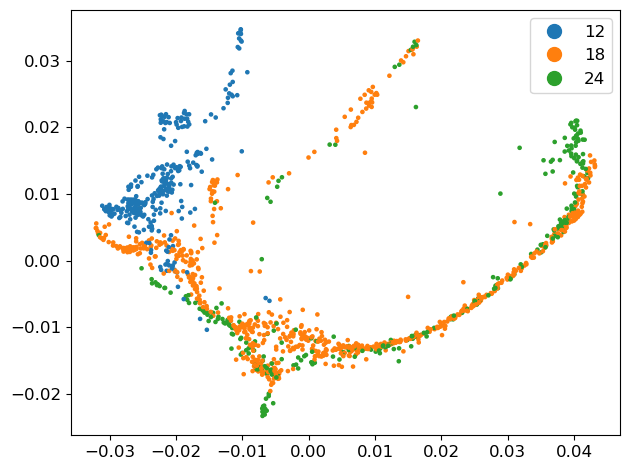

In [9]:
scprep.plot.scatter2d(
    adata.obsm[EMB_KEY],
#     c=adata.obs.n_genes_by_counts
    c=adata.obs.timepoint
)

In [15]:
adata.obsm[EMB_KEY]

array([[-0.02971507,  0.0069772 ],
       [-0.01674819,  0.01423773],
       [-0.02103766,  0.0110385 ],
       ...,
       [ 0.01067894, -0.01276582],
       [ 0.04067392,  0.01552639],
       [-0.00618704, -0.01095074]])

In [16]:
phate_x = adata.obsm[EMB_KEY][:, 0]
phate_y = adata.obsm[EMB_KEY][:, 1]
iroot = np.where((phate_y == np.max(phate_y[(phate_x < -0)])))[0][0]

<Axes: >

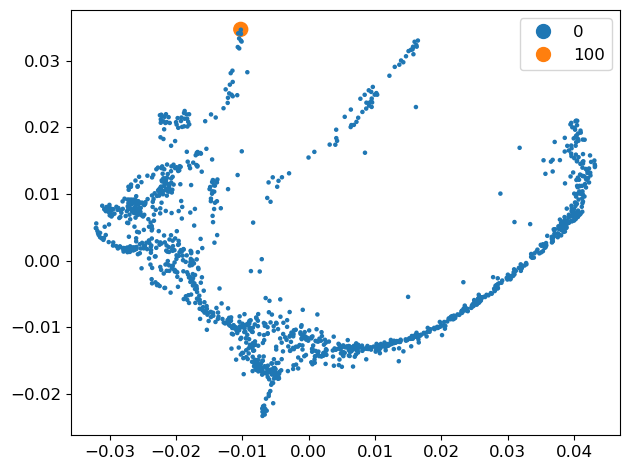

In [18]:
scprep.plot.scatter2d(
    adata.obsm[EMB_KEY], 
    c=[0 if i != iroot else 100 for i, e in enumerate(phate_y)],
    s=[5 if i != iroot else 100 for i, e in enumerate(phate_y)]
)

In [20]:
adata.uns['iroot'] = iroot
sc.pp.neighbors(adata)
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

<Axes: >

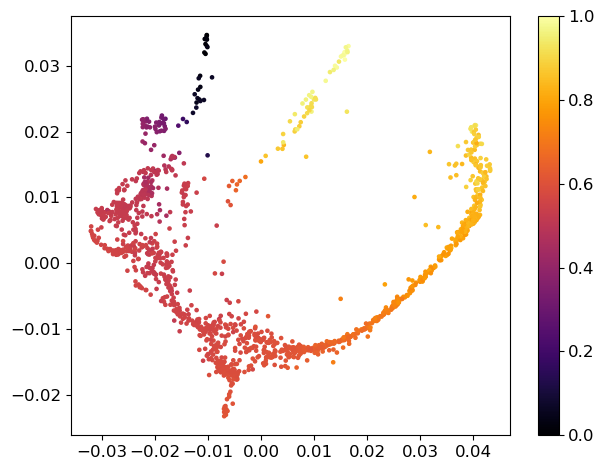

In [21]:
scprep.plot.scatter2d(
    adata.obsm[EMB_KEY], 
    c=adata.obs.dpt_pseudotime,
    azim=85, elev=20
)

In [23]:
# pip install -U degex

In [24]:
from degex.preprocessing import (
    prepare_h5ad_file,
    filter_pipeline,
    normalization_pipeline,
    embedding_pipeline,
)

from degex.adata import (
    combine_timepoints, add_gene_annotations,
    calc_qc_stats
) 
from degex.adata import apply_filter_by_cutoffs
from degex.types import CutoffSpecification
from degex.adata import remove_mitochondrial_genes
from degex.adata import (
    zscore_markers_in_layer, 
    subset_markers
)

In [25]:
df_counts = pd.DataFrame(
    np.array(adata.X.todense()),
    columns=adata.var.index,
    index=adata.obs.index
)
df_counts.head()

fgfr1op2  znf1114      ERC1  si:dkey-199m13.5  \
AAACGTACACTAAATC-1_0       0.0      0.0  2.342749               0.0   
AAAGCCGCATTAAAGG-1_0       0.0      0.0  0.000000               0.0   
AAAGGTTAGCCTGGTA-1_0       0.0      0.0  0.000000               0.0   
AAATCCGGTACGGGTT-1_0       0.0      0.0  3.863337               0.0   
AAATGCCTCGTTACTT-1_0       0.0      0.0  0.000000               0.0   

                      si:dkey-199m13.4  tm7sf3    dyrk2  lhfpl3  \
AAACGTACACTAAATC-1_0          0.000000     0.0  0.00000     0.0   
AAAGCCGCATTAAAGG-1_0          0.000000     0.0  1.96305     0.0   
AAAGGTTAGCCTGGTA-1_0          2.845552     0.0  0.00000     0.0   
AAATCCGGTACGGGTT-1_0          0.000000     0.0  0.00000     0.0   
AAATGCCTCGTTACTT-1_0          0.000000     0.0  0.00000     0.0   

                      si:dkeyp-82h4.3  znf1136  ...    pnpla2  CABZ01068600.1  \
AAACGTACACTAAATC-1_0              0.0      0.0  ...  0.000000             0.0   
AAAGCCGCATTAAAGG-1_0              0.0      0.0  ...  0.000000             0.0   
AAAGGTTAGCCTGGTA-1_0              0.0      0.0  ...  0.000000             0.0   
AAATCCGGTACGGGTT-1_0              0.0      0.0  ...  1.577201             0.0   
AAATGCCTCGTTACTT-1_0              0.0      0.0  ...  0.000000             0.0   

                      plxnb2b  nell2a  BRSK2    ZNF276  irx3b  isl2a  \
AAACGTACACTAAATC-1_0      0.0     0.0    0.0  2.342749    0.0    0.0   
AAAGCCGCATTAAAGG-1_0      0.0     0.0    0.0  0.000000    0.0    0.0   
AAAGGTTAGCCTGGTA-1_0      0.0     0.0    0.0  0.000000    0.0    0.0   
AAATCCGGTACGGGTT-1_0      0.0     0.0    0.0  0.000000    0.0    0.0   
AAATGCCTCGTTACTT-1_0      0.0     0.0    0.0  0.000000    0.0    0.0   

                          kras  BX004976.2  
AAACGTACACTAAATC-1_0  2.342749         0.0  
AAAGCCGCATTAAAGG-1_0  0.000000         0.0  
AAAGGTTAGCCTGGTA-1_0  0.000000         0.0  
AAATCCGGTACGGGTT-1_0  2.230499         0.0  
AAATGCCTCGTTACTT-1_0  0.000000         0.0  

[5 rows x 15616 columns]

In [59]:
pseudotime = (adata.obs.dpt_pseudotime * 100).astype(int)
np.unique(pseudotime, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,  12,  15,  18,  23,  27,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100]),
 array([  3,   4,   4,   1,   4,   2,   5,   2,   1,   1,   1,   1,   1,
          1,   1,   1,   3,   3,   4,   4,   2,   6,   5,   4,   1,   3,
          2,   3,   7,   7,   6,  12,  12,  19,  37, 126,  76,  54, 105,
         76,  50,  87,  63,  55,  42,  16,  20,  21,  18,  13,  19,   9,
         17,  14,  14,  14,  13,  11,  11,  16,  19,  16,  17,  18,  18,
         17,  21,  11,  17,  22,  17,  15,   7,   9,   6,   5,   4,   4,
          4,   6,   1,   5,   3,   1]))

In [60]:
ptimes = []

_bin = 0
for i, (num, cnt) in enumerate(zip(*np.unique(pseudotime, return_counts=True))):
    increment = True
    if cnt < 50:
#         _bin -= 1
        _bin = max(0, _bin)
        
        increment = False
    
    pseudotime[pseudotime == num] = _bin
    if increment:
        _bin += 1
        

np.unique(pseudotime, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([299,  76,  54, 105,  76,  50,  87,  63,  55, 531]))

<Axes: >

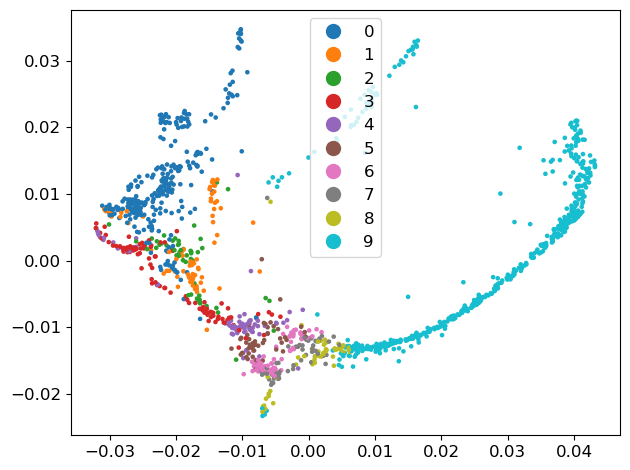

In [61]:
scprep.plot.scatter2d(
    adata.obsm[EMB_KEY], c=pseudotime
)

In [62]:
df_counts.loc[:, 'samples'] = pseudotime.astype(int)

In [63]:
phate_operator = phate.PHATE(n_components=10, n_jobs=-1)
Y_phate = phate_operator.fit_transform(df_counts.drop(columns='samples'.split()))

pca_loadings = phate_operator.graph.data_nu
pca_components = phate_operator.graph.data_pca.components_

Calculating PHATE...
  Running PHATE on 1396 observations and 15616 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.17 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.67 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 76.49 seconds.
Calculated PHATE in 77.67 seconds.


In [65]:
with open(os.path.join(PROCESSED_DIR, f'df_counts_{m_name}_pca_data.pkl'), 'wb') as f:
    pickle.dump(
        {
            'phate_operator': phate_operator,
            'Y_phate': Y_phate,
            'pca_loadings': pca_loadings,
            'pca_components': pca_components
        }, f
    )

# MIOFlow

In [68]:
# pip install git+https://github.com/KrishnaswamyLab/MIOFlow.git

In [69]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [70]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [71]:
df = pd.DataFrame(
    pca_loadings, columns=[f'd{i}' for i in range(1, 101)],
)
df.loc[:, 'samples'] = df_counts.samples.values
df.head()

d1         d2         d3         d4         d5         d6  \
0 -20.683901 -18.571449  -7.070555 -13.089079   5.064690  -6.739798   
1   3.399064   3.566346  -7.387465  27.506468  12.111789  -1.471878   
2 -14.758126  -2.488554  -7.227736  -0.221830  17.184095  10.616653   
3 -20.058130  -5.515769   8.948076  -6.916997  10.177391   5.332209   
4 -14.777461 -10.715414 -17.561134  -6.616876  18.653959  -5.315953   

          d7         d8        d9       d10  ...       d92       d93  \
0 -11.891020   4.893357 -4.800255 -5.322338  ... -1.107440 -0.485500   
1  -9.234814 -15.400686  5.727027  6.983614  ...  1.443962  0.002672   
2   7.033542  -7.719759  2.010926  2.664113  ...  2.689427  1.060517   
3 -19.380613  -4.960974 -8.570398 -0.249830  ... -1.643988  1.907722   
4   7.397265  -4.171570  8.164807  7.082566  ... -1.934891  4.998889   

        d94       d95       d96       d97       d98       d99      d100  \
0 -1.084647  4.336445 -1.509018  4.859576 -3.041816 -0.896985  3.772789   
1  2.124089  1.429167 -1.263276 -0.375444 -2.267832  0.359225  1.442087   
2 -5.960913 -4.256819 -0.177080  4.092051  2.950536  6.592113 -3.079567   
3 -2.775174  1.552185  5.773505  8.039581  2.160410 -5.190165 -2.046744   
4  3.782931 -0.837778 -1.112052  1.402553 -5.369435 -2.180738 -0.155759   

   samples  
0        1  
1        0  
2        0  
3        0  
4        0  

[5 rows x 101 columns]

## Train GAE

In [72]:
model_features = df.columns.size-1
groups = sorted(df.samples.unique())
hold_one_out = False; hold_out='random'

In [73]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'phate'
rbf_length_scale=0.5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 2
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

In [74]:
import warnings
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    if need_to_train_gae:
        start_time_geo = time.time()

        losses = train_ae(
            gae, df, groups, optimizer, 
            n_epochs=n_epochs_emb, sample_size=samples_size_emb,
            noise_min_scale=0.09, noise_max_scale=0.15, 
            dist=dist, recon=recon, use_cuda=use_cuda,
            hold_one_out=hold_one_out, hold_out=hold_out, 
            sample_with_replacement=True
        )
        run_time_geo = time.time() - start_time_geo

        print(run_time_geo)
        autoencoder = gae
    else:
        autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 21.36028
Train loss dist: 1531.73975
Train loss recon: 20.93597
Train loss dist: 440.52344
Train loss recon: 21.08314
Train loss dist: 205.64952
Train loss recon: 20.2105
Train loss dist: 402.63193
Train loss recon: 19.75544
Train loss dist: 253.79918
Train loss recon: 19.63758
Train loss dist: 188.05652
Train loss recon: 18.8572
Train loss dist: 140.76442
Train loss recon: 18.00651
Train loss dist: 185.27708
Train loss recon: 17.63801
Train loss dist: 167.6617
Train loss recon: 17.4865
Train loss dist: 158.32512
Train loss recon: 17.05902
Train loss dist: 201.0125
Train loss recon: 17.2796
Train loss dist: 126.01017
Train loss recon: 16.58979
Train loss dist: 171.51564
Train loss recon: 16.17698
Train loss dist: 146.57677
Train loss recon: 16.21638
Train loss dist: 189.79529
Train loss recon: 15.81107
Train loss dist: 124.58038
Train loss recon: 15.98254
Train loss dist: 182.02144
Train loss recon: 15.77466
Train loss dist: 135.02487
Train loss recon: 15.26715
Train 

## Setup MIOFlow

In [75]:
set_seeds(10)

#Directory where results are saved
exp_name = f'{c_name}_only'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 15

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [76]:
# Basically "batch size"
sample_size=(40, )

# Training specification
n_local_epochs = 2
n_epochs = 2
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = False
# each reverse_n epoch
reverse_n = 2

criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100

In [77]:
opts = {
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
}

In [78]:
exp_dir, logger = setup_exp(os.path.join(PROCESSED_DIR, 'mioflow'), opts, exp_name) 

In [79]:
exp_dir

'/gpfs/gibbs/pi/krishnaswamy_smita/Boswell_Multiome_2023/processed/mioflow/pm_cells_only'

## Train MIOFlow

In [80]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    
    sample_with_replacement=True,
    
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params
    
    plot_every=None,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [83]:
fig_dir = os.path.join(exp_dir, 'figures')
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

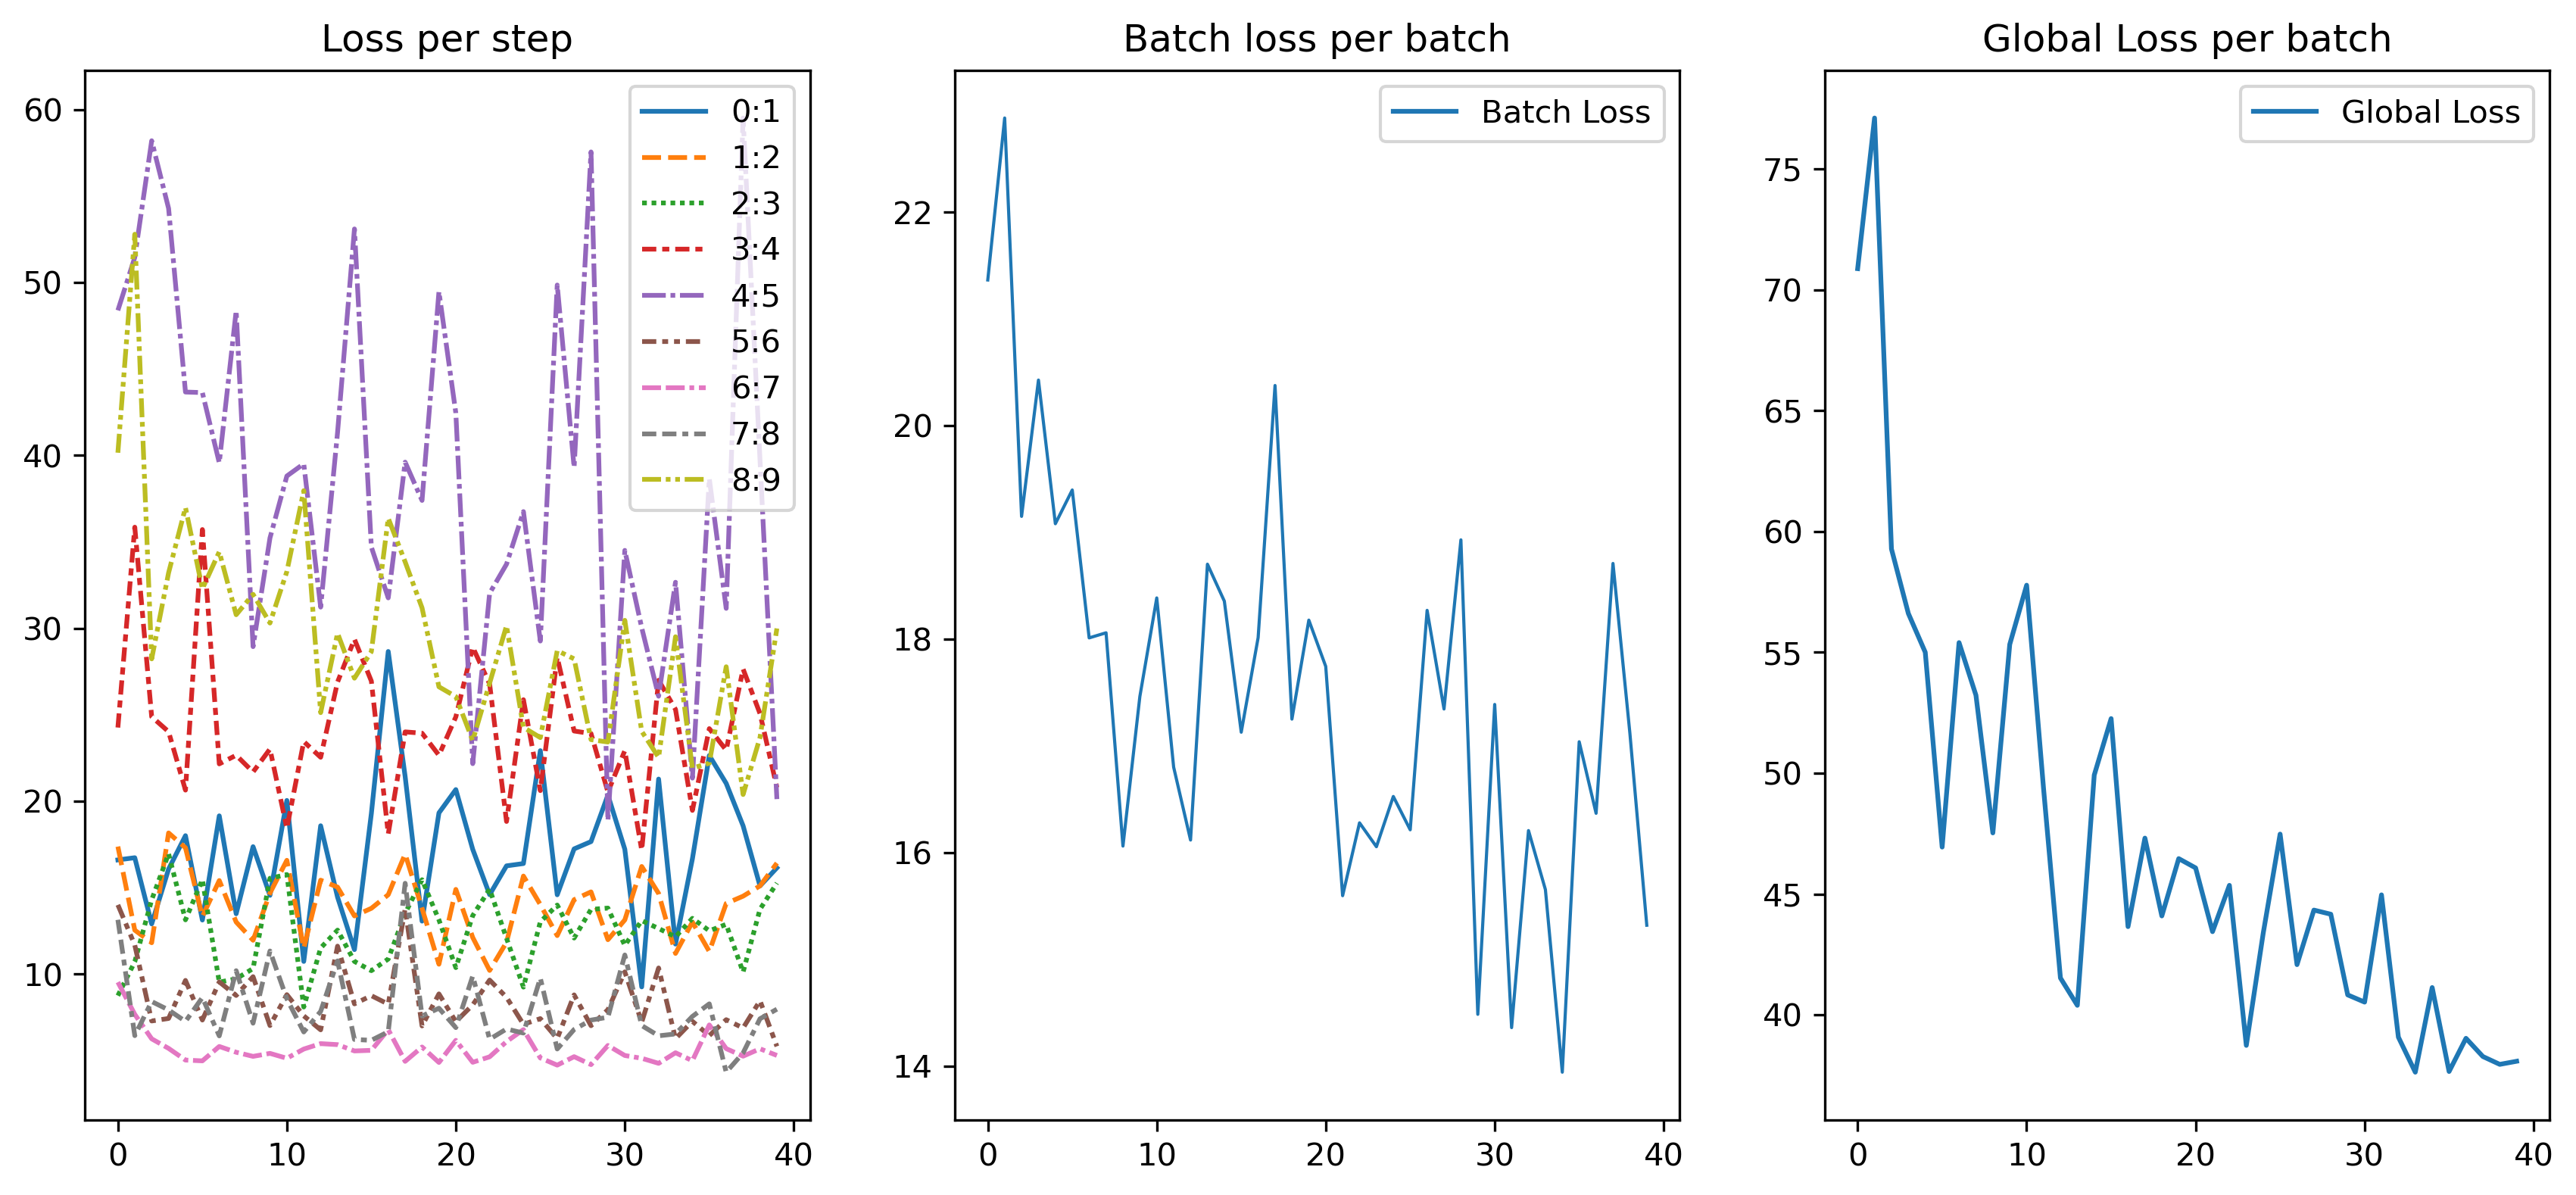

In [84]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=fig_dir, file='losses.png'
)

## Save Model

In [ ]:
torch.save(model, os.path.join(exp_dir, 'model.torch'))
torch.save(autoencoder, os.path.join(exp_dir, 'autoencoder.torch'))

## Trajectories in PCA Space

In [85]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

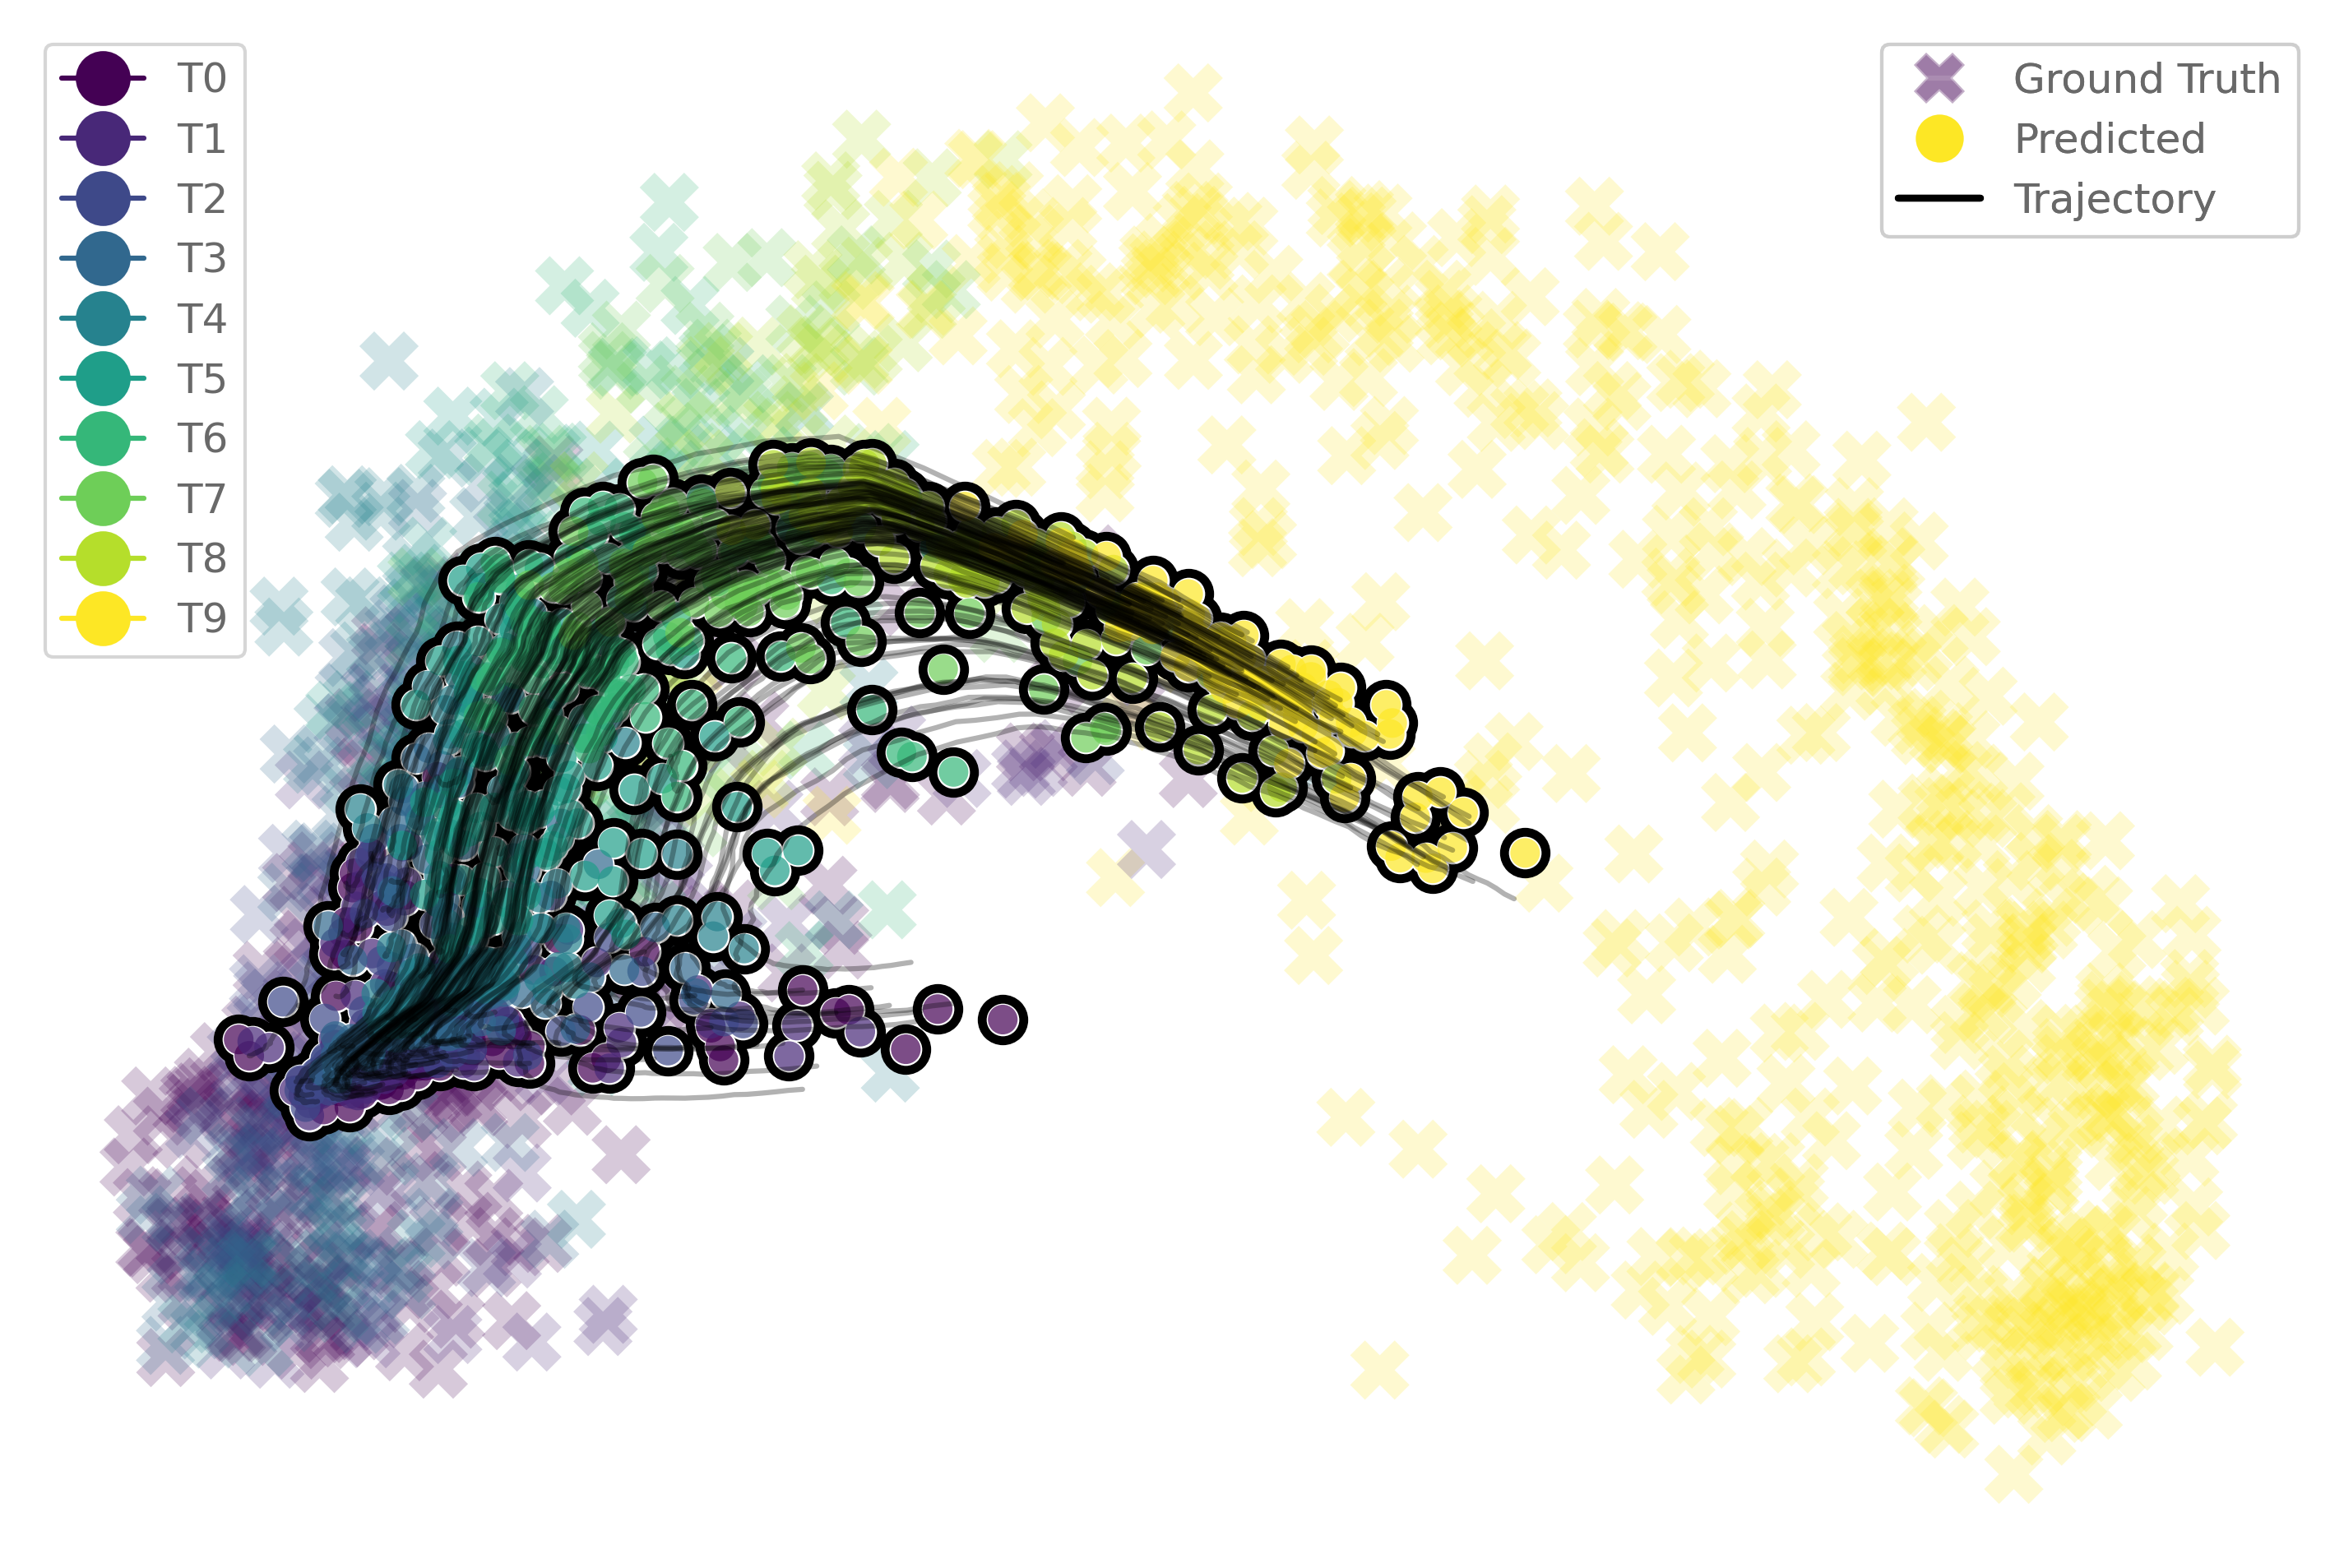

In [86]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=fig_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

## Trajectories in GAE Latent space

In [87]:
latent_cells = autoencoder.encoder(torch.Tensor(df.drop(columns='samples').values).cuda())
latent_cells = latent_cells.detach().cpu().numpy()
latent_cells.shape

(1396, 2)

### Ground truth latent cells

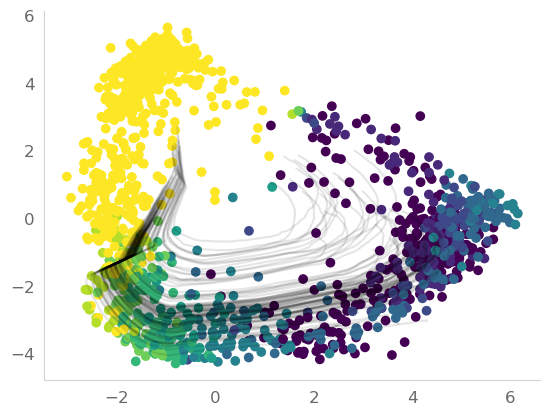

In [88]:
# GT latent cells
plt.scatter(
    latent_cells[:, 0], latent_cells[:, 1],
    c=df.samples
)

res = []
for _bin in np.transpose(trajectories, axes=(1,0,2)):
    latent = autoencoder.encoder(torch.Tensor(_bin).cuda())
    latent = latent.detach().cpu().numpy()
    res.append(latent.tolist())
res = np.array(res)

for trajectory in res:#np.transpose(res, axes=(1,0,2)):
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.1, color='Black');

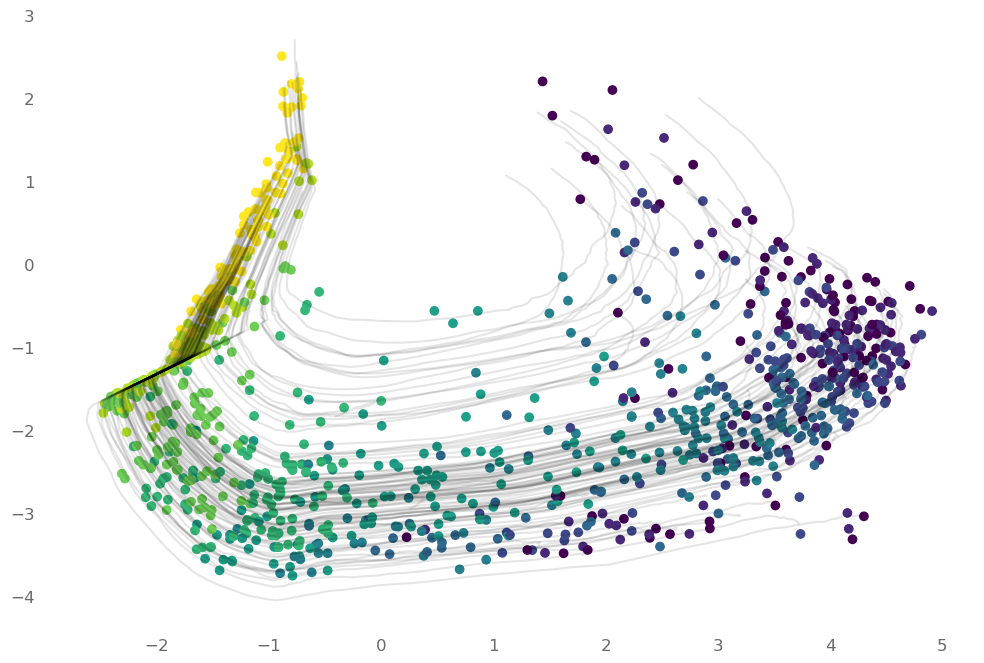

In [90]:
fig = plt.figure(figsize=(12, 8))
n_timepoints = df.samples.unique().size

pnt_res = []
for _bin in np.transpose(generated, axes=(1,0,2)):
    latent = autoencoder.encoder(torch.Tensor(_bin).cuda())
    latent = latent.detach().cpu().numpy()
    pnt_res.append(latent.tolist())

pnt_res = np.array(pnt_res)
cmap = plt.get_cmap()
for i, _bin in enumerate(pnt_res):
    plt.scatter(_bin[:, 0], _bin[:, 1], c=[cmap(i/(n_timepoints-1)) for i in range(len(_bin))])


trj_res = []
for _bin in np.transpose(trajectories, axes=(1,0,2)):
    latent = autoencoder.encoder(torch.Tensor(_bin).cuda())
    latent = latent.detach().cpu().numpy()
    trj_res.append(latent.tolist())
trj_res = np.array(trj_res)
for trajectory in trj_res:
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.1, color='Black');
    

sns.despine(trim=True, left=True, bottom=True)
fig.savefig(os.path.join(fig_dir, f'{m_name}_gae_latent_space.png'))

In [91]:
df_m = df_counts.drop(columns='samples')
pcs = pca_components
use_cell_types = False

In [92]:
from MIOFlow.utils import to_np, get_groups_from_df, get_cell_types_from_df, get_sample_n_from_df
from MIOFlow.eval import generate_tjnet_trajectories, get_cell_indexes
from MIOFlow.plots import plot_gene_trends

In [93]:
where = 'start'
start = 0
use_cell_types = False

tjnet_trajectories = generate_tjnet_trajectories(
    model, df, use_cuda=use_cuda, autoencoder=autoencoder, recon=recon,
    where=where, start=start, 
)

In [100]:
GENES = adata.var[adata.var.highly_variable & adata.var.TFs].index.values

In [101]:
genes = GENES

In [102]:
genes, top_idxs, inverse, colors = get_cell_indexes(
    df_m, genes, tjnet_trajectories, pca_components, 
    where=where, start=start, samples=df.samples, use_cell_types=use_cell_types,
    palette='tab20',
)

fig = plot_gene_trends(
    genes, top_idxs, inverse, colors, n_cols=4, samples=df.samples, where=where, start=start, 
    cell_types='AT1 AT2 Repair'.split(), use_cell_types=use_cell_types
)

In [103]:
fig.savefig(os.path.join(fig_dir, 'mega.png'))

In [104]:
import itertools
from degex.granger import GrangerCausality, trajectories_to_genes_x_timebins

In [105]:
genes_x_timebins = trajectories_to_genes_x_timebins(inverse)
df_trj = pd.DataFrame(genes_x_timebins, index=genes)
df_trj

0         1         2         3         4         5         6   \
fbxo18  0.121465  0.123061  0.124622  0.126116  0.127558  0.128909  0.130197   
nfyba  -0.006697 -0.006813 -0.006920 -0.006985 -0.006996 -0.006966 -0.006859   
yaf2   -0.018130 -0.018030 -0.017919 -0.017793 -0.017650 -0.017493 -0.017319   
terfa   0.043250  0.043555  0.043845  0.044109  0.044351  0.044560  0.044733   
tmpoa   0.136284  0.138146  0.140014  0.141899  0.143859  0.145801  0.147821   
...          ...       ...       ...       ...       ...       ...       ...   
arid3b  0.953817  0.959379  0.964512  0.969030  0.973063  0.976527  0.979454   
roraa  -0.017485 -0.017734 -0.017973 -0.018205 -0.018415 -0.018613 -0.018807   
pot1    0.017839  0.018101  0.018404  0.018747  0.019193  0.019673  0.020218   
rfx7b   0.012906  0.013133  0.013383  0.013653  0.013956  0.014272  0.014611   
e2f4    0.014039  0.014484  0.014934  0.015416  0.015929  0.016462  0.017045   

              7         8         9   ...        90        91        92  \
fbxo18  0.131391  0.132400  0.133310  ... -0.074456 -0.074872 -0.075285   
nfyba  -0.006677 -0.006482 -0.006205  ... -0.036437 -0.040104 -0.043476   
yaf2   -0.017136 -0.016947 -0.016741  ...  0.008883  0.007039  0.005195   
terfa   0.044873  0.044972  0.045036  ... -0.007797 -0.007775 -0.007827   
tmpoa   0.149897  0.151769  0.153717  ... -0.123141 -0.133978 -0.144301   
...          ...       ...       ...  ...       ...       ...       ...   
arid3b  0.981876  0.983424  0.984177  ... -0.595520 -0.602933 -0.609850   
roraa  -0.018977 -0.019119 -0.019237  ...  0.027207  0.024175  0.021111   
pot1    0.020854  0.021480  0.022213  ...  0.071878  0.057795  0.043840   
rfx7b   0.014981  0.015333  0.015728  ...  0.001344 -0.001327 -0.003941   
e2f4    0.017651  0.018229  0.018853  ... -0.032438 -0.034639 -0.036688   

              93        94        95        96        97        98        99  
fbxo18 -0.075722 -0.076193 -0.076749 -0.077316 -0.077889 -0.078480 -0.079096  
nfyba  -0.046668 -0.049512 -0.052087 -0.054334 -0.056317 -0.057963 -0.059282  
yaf2    0.003336  0.001457 -0.000395 -0.002193 -0.003909 -0.005527 -0.007052  
terfa  -0.007945 -0.008157 -0.008482 -0.008928 -0.009504 -0.010221 -0.011061  
tmpoa  -0.154378 -0.163953 -0.173142 -0.181741 -0.189799 -0.197173 -0.203881  
...          ...       ...       ...       ...       ...       ...       ...  
arid3b -0.616404 -0.621900 -0.627204 -0.631875 -0.636230 -0.640115 -0.643471  
roraa   0.017996  0.014800  0.011599  0.008355  0.005094  0.001850 -0.001362  
pot1    0.029823  0.015773  0.001904 -0.011739 -0.025101 -0.038026 -0.050489  
rfx7b  -0.006535 -0.009095 -0.011603 -0.014039 -0.016366 -0.018556 -0.020613  
e2f4   -0.038664 -0.040461 -0.042156 -0.043642 -0.044973 -0.046118 -0.047087  

[259 rows x 100 columns]

In [106]:
gc_op = GrangerCausality(n_jobs=2)
df_res = gc_op.fit_transform(df_trj, fit_params={'standard_scaler':True, 'signed_correlation': True})

In [108]:
fig_dir

'/gpfs/gibbs/pi/krishnaswamy_smita/Boswell_Multiome_2023/processed/mioflow/pm_cells_only/figures'

<Figure size 1200x800 with 0 Axes>

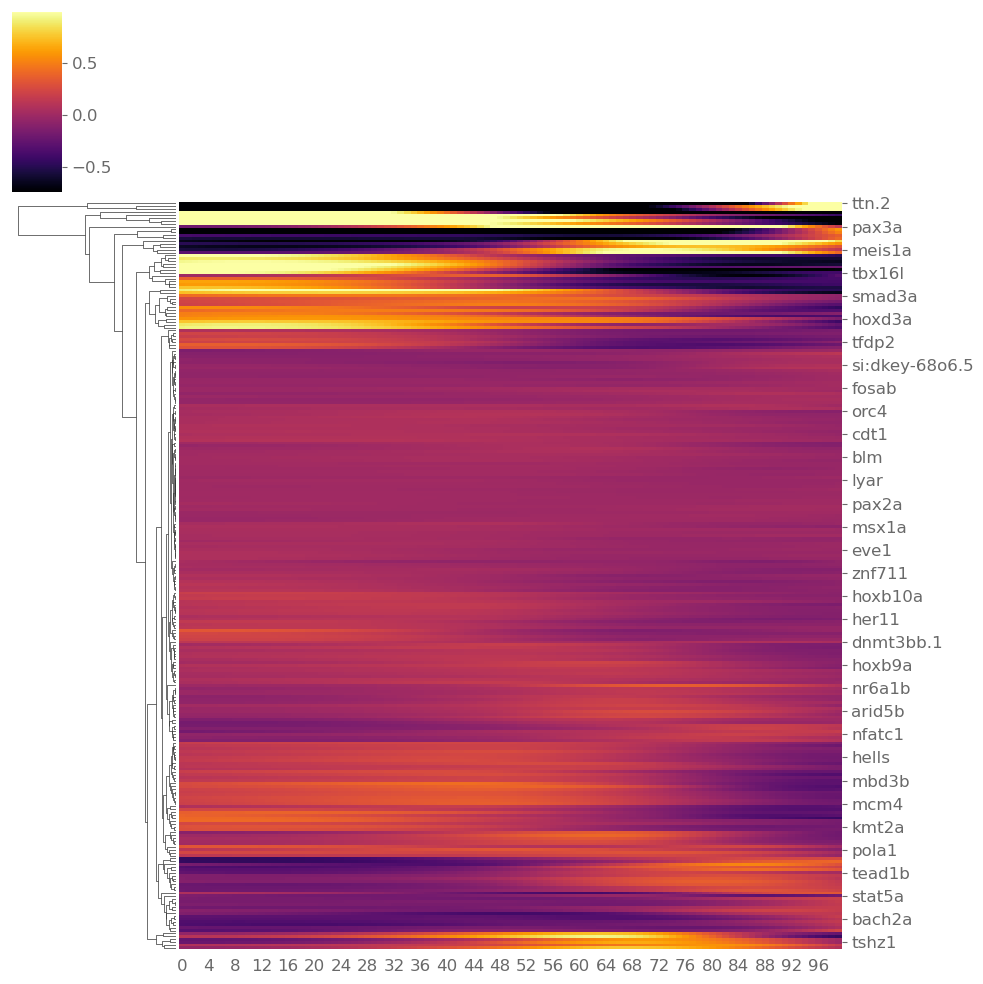

In [113]:
fig = plt.figure(figsize=(12, 8))
ax = sns.clustermap(
    gc_op.df_org, cmap='inferno', robust=True,
    col_cluster=False, 
)
ax.savefig(os.path.join(fig_dir, f'{m_name}_boswell_gene_trends_heatmap.png'))

# gc_op.plot_df_org()

<Figure size 1200x800 with 0 Axes>

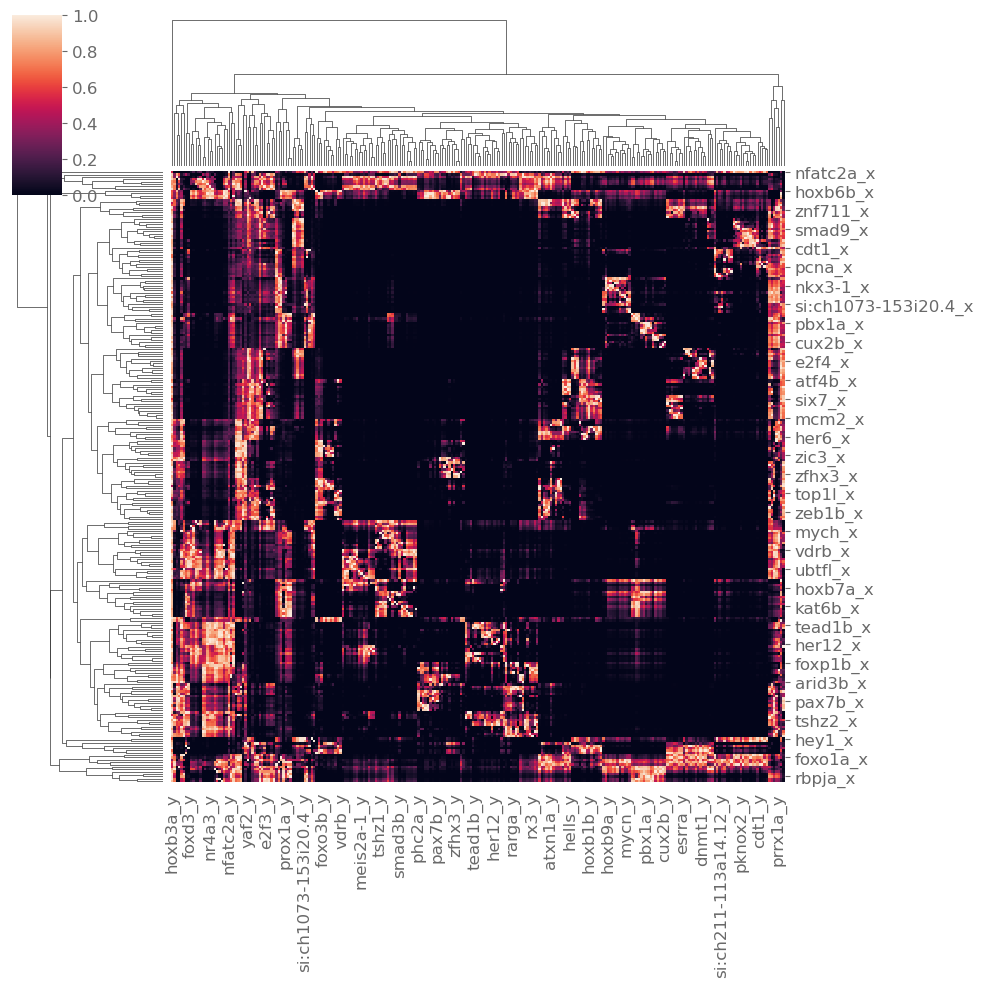

In [114]:
ax = gc_op.plot_df_res()
ax.savefig(os.path.join(fig_dir, f'{m_name}_boswell_gene_trends_granger.png'))